Now I'm re-running XHMM to remove targets with high GC content and also low complexity. Like the previous analysis, I'll run only the simplex families with at least 2 kids in them, for the contrast between affected and unaffected. Also have to remember to remove the other 2 samples we always removed, and I'm also removing samples from the 9030 family.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [5]:
import glob
ped_files = ['/data/sudregp/multiplex_simplex/simplex.ped']
wes_prefix = ['CLIA', 'CCGO', 'WPS']
# fid = open('/home/sudregp/data/multiplex_simplex/samples_simplex_all.txt', 'r')
# exclude_list = [line.rstrip() for line in fid]
# fid.close()

# no controls/affected pair for comparison
exclude_list = ['CLIA_400165', 'CLIA_400164', 'CLIA_400155', 'CLIA_400146',
                'CLIA_400145', 'CLIA_400126', 'CLIA_400207', 'CLIA_400208',
                'CLIA_400209']
# missing one parent
exclude_list += ['CLIA_400169', 'CLIA_400168']
# family 9030
exclude_list += ['CCGO_800978', 'CCGO_800977', 'CCGO_800976', 'CCGO_800979',
                 'CCGO_800980', 'CLIA_400067']

trios = []
affected = []
controls = []
samples = []
famids = []
for ped_file in ped_files:
    fid = open(ped_file, 'r')
    for line in fid:
        famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
        # if the current ID and its parents have WES data, and the sample is 
        # not in yet
        if (fa.split('_')[0] in wes_prefix and
            mo.split('_')[0] in wes_prefix and
            sid.split('_')[0] in wes_prefix and
            sid not in samples and
            (sid not in exclude_list or fa not in exclude_list or mo not in exclude_list)):
            fam = {}
            fam['child'] = sid
            if aff == '1':
                affected.append(sid)
            else:
                controls.append(sid)
            fam['father'] = fa
            fam['mother'] = mo
            fam['famid'] = famid
            trios.append(fam)
            samples += [sid, fa, mo]
            famids.append(famid)
    fid.close()
samples = set(samples)
famids = set(famids)
kids = set(affected + controls)

print 'Unique samples:', len(samples)
print 'Unique families:', len(famids)
print 'Unique children:', len(kids)

Unique samples: 84
Unique families: 19
Unique children: 46


In [6]:
fid = open('/data/sudregp/cnv/xhmm_clean2/samples.txt', 'w')
for s in samples:
    fid.write(s + '\n')
fid.close()

fid = open('/data/sudregp/cnv/xhmm_clean2/kid_samples.txt', 'w')
for s in kids:
    fid.write(s + '\n')
fid.close()

In [ ]:
# in terminal
exome_targets='/data/NCR_SBRB/simplex/SeqCapEZ_Exome_v3.0_Design_Annotation_files/SeqCap_EZ_Exome_v3_hg19_capture_targets.bed'
gatk_memory="50g"
ref_fa='/fdb/GATK_resource_bundle/hg19-2.8/ucsc.hg19.fasta'
out_dir='/data/sudregp/cnv/xhmm_clean2'

cd $out_dir
module load GATK
module load XHMM

GATK -m ${gatk_memory} GCContentByInterval -L ${exome_targets} -R ${ref_fa} -o ./DATA.locus_GC.txt
cat ./DATA.locus_GC.txt | awk '{if ($2 < 0.1 || $2 > 0.9) print $1}' > ./extreme_gc_targets.txt

# merging all subjects in the directory
while read s; do
    cp ../xhmm_clean/${s}* .
done < samples.txt
ls -1 *.sample_interval_summary > depth_list.txt;
cp ../xhmm_clean/params.txt .

xhmm --mergeGATKdepths --GATKdepthsList=depth_list.txt -o ./DATA.RD.txt;

# this does the same thing as the XHMM script, but it actually works in parsing 
# the base pair start and ends
cat ${exome_targets} | awk 'BEGIN{OFS="\t"; print "#CHR\tBP1\tBP2\tID"}{print $1, $2, $3, NR}' > ./EXOME.targets.reg

module load plinkseq
pseq . loc-load --locdb ./EXOME.targets.LOCDB --file ./EXOME.targets.reg --group targets \
    --out ./EXOME.targets.LOCDB.loc-load --noweb

# this has the same effect as the suggested command, but it actually works
pseq . loc-stats --locdb ./EXOME.targets.LOCDB --group targets --seqdb ./seqdb.hg19 --noweb | \
    awk '{if (NR > 1) { print  $4, $10 }}' | sed 's/\.\./-/' - > ./DATA.locus_complexity.txt

cat ./DATA.locus_complexity.txt | awk '{if ($2 > 0.25) print $1}' > ./low_complexity_targets.txt

xhmm --matrix -r ./DATA.RD.txt --centerData --centerType target \
-o ./DATA.filtered_centered.RD.txt \
--outputExcludedTargets ./DATA.filtered_centered.RD.txt.filtered_targets.txt \
--outputExcludedSamples ./DATA.filtered_centered.RD.txt.filtered_samples.txt \
--excludeTargets ./extreme_gc_targets.txt --excludeTargets ./low_complexity_targets.txt \
--minTargetSize 10 --maxTargetSize 10000 \
--minMeanTargetRD 10 --maxMeanTargetRD 500 \
--minMeanSampleRD 25 --maxMeanSampleRD 200 \
--maxSdSampleRD 150

xhmm --PCA -r ./DATA.filtered_centered.RD.txt --PCAfiles ./DATA.RD_PCA

xhmm --normalize -r ./DATA.filtered_centered.RD.txt --PCAfiles ./DATA.RD_PCA \
--normalizeOutput ./DATA.PCA_normalized.txt \
--PCnormalizeMethod PVE_mean --PVE_mean_factor 0.7

xhmm --matrix -r ./DATA.PCA_normalized.txt --centerData --centerType sample --zScoreData \
-o ./DATA.PCA_normalized.filtered.sample_zscores.RD.txt \
--outputExcludedTargets ./DATA.PCA_normalized.filtered.sample_zscores.RD.txt.filtered_targets.txt \
--outputExcludedSamples ./DATA.PCA_normalized.filtered.sample_zscores.RD.txt.filtered_samples.txt \
--maxSdTargetRD 30

xhmm --matrix -r ./DATA.RD.txt \
--excludeTargets ./DATA.filtered_centered.RD.txt.filtered_targets.txt \
--excludeTargets ./DATA.PCA_normalized.filtered.sample_zscores.RD.txt.filtered_targets.txt \
--excludeSamples ./DATA.filtered_centered.RD.txt.filtered_samples.txt \
--excludeSamples ./DATA.PCA_normalized.filtered.sample_zscores.RD.txt.filtered_samples.txt \
-o ./DATA.same_filtered.RD.txt

xhmm --discover -p params.txt -r ./DATA.PCA_normalized.filtered.sample_zscores.RD.txt \
    -R ./DATA.same_filtered.RD.txt -c ./DATA.xcnv -a ./DATA.aux_xcnv -s ./DATA

xhmm --genotype -p params.txt -r ./DATA.PCA_normalized.filtered.sample_zscores.RD.txt \
    -R ./DATA.same_filtered.RD.txt -g ./DATA.xcnv -F $ref_fa -v ./DATA.vcf



Let's make sure no sample was removed by XHMM this time:

In [1]:
%%bash
cd ~/data/cnv/xhmm_clean2/
ls -ltr DATA.filtered_centered.RD.txt.filtered_samples.txt

-rw-rw---- 1 sudregp sudregp 0 Feb  5 17:09 DATA.filtered_centered.RD.txt.filtered_samples.txt


Now we create PSEQ and PLINK files.

In [ ]:
#in terminal
module load plinkseq
module load plink/1.07

cd ~/data/cnv/xhmm_clean2

pseq DATA new-project
# adding a first column with subject ID for PSEQ
cut -f 2 ../simplex.ped > junk.txt
paste junk.txt ../simplex.ped > simplex.ped.info
pseq DATA load-pedigree --file simplex.ped.info
pseq DATA load-vcf --vcf DATA.vcf

for q in 50 60 70 80 90; do
    pseq DATA cnv-denovo --noweb --minSQ $q --minNQ $q --out DATA_q${q}
    grep DENOVO DATA_q${q}.denovo.cnv > pseq_DENOVO.txt
    # borrow the header row
    head -1 DATA.xcnv > denovo.xcnv;

    # filter out denovo CNVs
    while read sample; do
        grep $sample DATA.xcnv > sample.xcnv;
        for cnv in `grep $sample pseq_DENOVO.txt | cut -f 3 -`; do
            # replacing .. by -
            cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
            grep $cnv sample.xcnv >> denovo.xcnv; 
        done;
    done < kid_samples.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv denovo.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > denovo_q${q}.cnv
    rm sample.xcnv pseq_DENOVO.txt tmp.cnv denovo.xcnv
    
    # filter out inherited cnvs
    grep MATERNAL_TRANSMITTED DATA_q${q}.denovo.cnv > pseq_TRANSMITTED.txt
    grep PATERNAL_TRANSMITTED DATA_q${q}.denovo.cnv >> pseq_TRANSMITTED.txt
    # borrow the header row
    head -1 DATA.xcnv > inherited.xcnv;

    while read sample; do
        grep $sample DATA.xcnv > sample.xcnv;
        for cnv in `grep $sample pseq_TRANSMITTED.txt | cut -f 3 -`; do
            # replacing .. by -
            cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
            grep $cnv sample.xcnv >> inherited.xcnv; 
        done;
    done < kid_samples.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv inherited.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > inherited_q${q}.cnv
    rm sample.xcnv pseq_TRANSMITTED.txt tmp.cnv inherited.xcnv
    
    # compile all CNVs for kids
    # borrow the header row
    head -1 DATA.xcnv > all.xcnv;

    # effectively just filtering DATA.xcnv to keep only kids
    while read sample; do
        grep $sample DATA.xcnv >> all.xcnv;
    done < kid_samples.txt;
    /usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv all.xcnv > tmp.cnv
    # switch around FAMID and IID columns, and remove header
    awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > all_q${q}.cnv
    rm tmp.cnv all.xcnv
done

In [ ]:
#terminal

cp ~/data/cnv/penncnv/wellknown_region_hg19 bad_regions.list
cp ~/data/cnv/penncnv/glist-hg19 .
cp ~/data/cnv/penncnv/genes.txt .
cp ~/data/cnv/penncnv/hg19_allenBrainGene_trimmed.txt .

for q in 50 60 70 80 90; do
    for cnvtype in all denovo inherited; do
        cnvname=${cnvtype}_q${q}.cnv
        plink --cnv-list $cnvname --cnv-make-map --noweb --out ${cnvtype}_q${q};
        
        # remove bad regions
        plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-exclude bad_regions.list --cnv-overlap .5 \
            --cnv-write --out ${cnvtype}_q${q}_clean
        plink --cnv-list ${cnvtype}_q${q}_clean.cnv --cnv-make-map --noweb --1 \
            --out ${cnvtype}_q${q}_clean
        
        for qc in '' '_clean'; do
            cnvname=${cnvtype}_q${q}${qc}.cnv
            # whole burden
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-check-no-overlap --out ${cnvtype}_q${q}${qc}_burden;
            # gene sets
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset genes.txt --out ${cnvtype}_q${q}${qc}_genes;
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset hg19_allenBrainGene_trimmed.txt \
                --out ${cnvtype}_q${q}${qc}_brainGenes;
            # subtypes only
            for sub in del dup; do
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-${sub} --out ${cnvtype}_q${q}${qc}_${sub}Burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-${sub} \
                    --out ${cnvtype}_q${q}${qc}_${sub}Genes;
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                    --out ${cnvtype}_q${q}${qc}_${sub}BrainGenes;
            done;
        done;
    done;
done

Let's check the distributions:

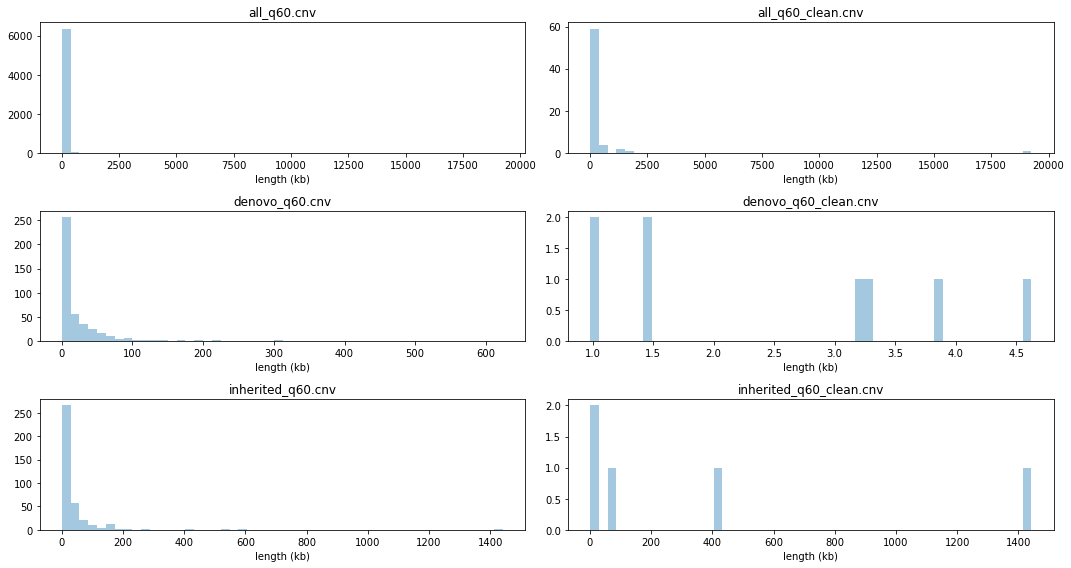

In [7]:
data_dir = '/home/sudregp/data/cnv/xhmm_clean2/'
files = glob.glob(data_dir + '/*_q60*.cnv')
files.sort()
plt.figure(figsize=(15,8))
i = 1
for fname in files:
    if fname.find('DATA') < 0:
        plt.subplot(3, 2, i)
        # the clean files have a header
        if fname.find('clean') >= 0:
            df = pd.read_table(fname, header=None, skiprows=1, delimiter='\s+')
        else:
            df = pd.read_table(fname, header=None)
        sns.distplot((df[4]-df[3])/1000, kde=False, bins=50)
        plt.xlabel('length (kb)')
        plt.title(fname.split('/')[-1])
        i += 1
plt.tight_layout()

Well, some quite big CNVs to be explored again... let's make the LT datasets:

In [ ]:
#terminal

module load plink/1.07

cd ~/data/cnv/xhmm_clean2
for q in 50 60 70 80 90; do
    for cnvtype in all denovo inherited; do
        for qc in '' '_clean'; do
            for kb in 250 500; do
                cnvname=${cnvtype}_q${q}${qc}.cnv
                # whole burden
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-check-no-overlap --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_genes;
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_brainGenes;
                # subtypes only
                for sub in del dup; do
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-${sub} --cnv-max-kb $kb \
                    --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Burden;
                    # gene sets
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset genes.txt --cnv-${sub} --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}Genes;
                    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                        --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                        --cnv-max-kb $kb \
                        --out ${cnvtype}_q${q}${qc}_lenLT${kb}_${sub}BrainGenes;
                done;
            done;
        done;
    done;
done

And let's see if the previous results hold:

In [1]:
%%bash
cd ~/data/cnv/xhmm_clean2
echo "=== ALL > 225Kb ==="
cat denovo_q60.cnv | awk '{ if (($5-$4)/1000 > 225) { print $_, ($5-$4)/1000 } }'
echo "=== CLEAN > 5Kb ==="
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 5) { print $_, ($5-$4)/1000 } }'

=== ALL > 225Kb ===
1	CLIA_400205	16	33402023	33630152	1	93	12 228.129
1	CLIA_400133	16	33326701	33630152	3	93	16 303.451
1	CLIA_400210	16	32264765	32889185	3	93	25 624.42
1	CLIA_400216	16	33326701	33630152	3	93	16 303.451
1	CLIA_400216	17	44379939	44627953	3	95	32 248.014
=== CLEAN > 5Kb ===


This is weird... 400178 is not even there anymore?

In [2]:
%%bash
cd ~/data/cnv/xhmm_clean2
cat denovo_q60_clean.cnv | awk '{ if (($5-$4)/1000 > 0) { print $_, ($5-$4)/1000 } }'

   1   CLIA_400200    6     27276759     27279927      3           90       19  3.168
   1   CLIA_400170    1    153945103    153946111      3           65        6  1.008
   1   CLIA_400178    2     21362374     21366206      1           65       22  3.832
   1   CLIA_400178   14     55511801     55513280      1           77        8  1.479
   1   CLIA_400178   18     19446875     19450166      1           96       11  3.291
   1   CLIA_400139    1    110883168    110884147      3           61        7  0.979
   1   CLIA_400139    4     38798624     38800077      3           93       11  1.453
   1   CLIA_400149   23    101615646    101620272      3           72        4  4.626


In [8]:
print 'CLIA_400200' in affected
print 'CLIA_400170' in affected

False
False


It's very weird that just by removing 4 samples from my previous cohort of 88 I get very different results!

# Questions:

* are these the only differences between the two samples?
* can I re-run both samples and repeat the results?
* maybe XHMM is not as stable as I'd like, and may need to use other tools